In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Issues
    1. exclude presented edge or not? 
        1. do not exclude currently.
        2. it is a useful variable to see if it's presented already or not, (might put it to ERGM to see if high correlation between networks is due to it has presented already 
        3. excluding presented edge to predict new edge occur in the future is a way, but we want to preserve this information
    
    2. should exclude new presented nodes in testing network, otherwise there's no way to predict
    
    3. however, when using edge betweenness in testing network, we want to see its importance in its current/future network, not the one excludes new nodes.
    
    4. try to find the threshold, the output only presents predict links
    
    5. AUR ROC , (x,y)-(katz, betweenness), plot with z-score to scale, compare different algorithms(tp only), further can compare tp,fp,tn,fn
    
    6. add one more column, cluster coefficient of edge

## 

In [2]:
import os
import pandas as pd

journal = input('scientometrics / jasist')
entity = input('co-author / co-occurrence')

path = os.getcwd()
evaluation_path = path+"\\output prediction\\{}\\{}\\evaluation\\".format(journal, entity)
result_path = path+"\\output prediction\\{}\\{}\\result\\".format(journal, entity)
betweenness_path = path+"\\output prediction\\{}\\{}\\".format(journal, entity)+"edge_betweenness.txt"

netfiles_path = path+"\\data_transformation_output\\{}\\netfiles\\{}\\".format(journal, entity)
netfiles = []
for f in os.listdir(netfiles_path):
    if f.endswith('.net'):
        netfiles.append(netfiles_path+f)

netfiles

scientometrics / jasistscientometrics
co-author / co-occurrenceco-occurrence


['C:\\Users\\Liser\\Desktop\\linchengwei_link_prediction\\data_transformation_output\\scientometrics\\netfiles\\co-occurrence\\2010-15.net',
 'C:\\Users\\Liser\\Desktop\\linchengwei_link_prediction\\data_transformation_output\\scientometrics\\netfiles\\co-occurrence\\2016-16.net',
 'C:\\Users\\Liser\\Desktop\\linchengwei_link_prediction\\data_transformation_output\\scientometrics\\netfiles\\co-occurrence\\2016-17.net',
 'C:\\Users\\Liser\\Desktop\\linchengwei_link_prediction\\data_transformation_output\\scientometrics\\netfiles\\co-occurrence\\2016-18.net',
 'C:\\Users\\Liser\\Desktop\\linchengwei_link_prediction\\data_transformation_output\\scientometrics\\netfiles\\co-occurrence\\2016-19.net']

# read Result

In [9]:
result = dict()

for f in os.listdir(result_path):
    df_iter = pd.read_csv(result_path+f, sep='\t', header=None)
    df_iter.columns=['keyword1', 'keyword2', f.split('.')[0]]
    result[f.split('.')[0]] = df_iter
    print(f)

AdamicAdar_t1.txt
jaccard_t1.txt
katz_beta001_t1.txt
katz_beta01_t1.txt


# read evaluation

In [3]:
eva = dict()
for f in os.listdir(evaluation_path):
    df_iter = pd.read_csv(evaluation_path+f, sep=' ', header=None)
    df_iter.columns = ['tp', 'fp', 'fn', 'tn']
    eva[f.split('.')[0]] = df_iter
    print(f)

AdamicAdar_t1.txt
jaccard_t1.txt
katz_beta001_t1.txt
katz_beta01_t1.txt


# read Betweenness

In [4]:
df_betweenness = pd.read_csv(betweenness_path, sep='\t', header=None)
df_betweenness.columns = ['keyword1', 'keyword2', 'betweenness']
df_betweenness = df_betweenness.set_index(['keyword1', 'keyword2'])

## nodes in testing phase
1. find all possible links

In [5]:
import linkpred
G = linkpred.read_network(netfiles[0]) # t1
n = len(list(G.nodes))
print("{} nodes in {}".format(n, netfiles[0]))

all_possible_links = (n*(n-1))/2
print("all possible links: {}".format(all_possible_links))

Network contains multiple edges. These will be ignored.


4351 nodes in C:\Users\Liser\Desktop\linchengwei_link_prediction\data_transformation_output\scientometrics\netfiles\co-occurrence\2010-15.net
all possible links: 9463425.0


## computing confusion and new evaluation with correct tn

In [6]:
import numpy as np

def compute_confusion(evaluation, num_linked, num_of_nolink):
    
    def add_0_for_cal(X):
        
        C = pd.DataFrame()
        C = C.append([[0, 0, num_linked, num_of_nolink]])
        C.columns = X.columns
        X = C.append(X)
        
        return X

    X = add_0_for_cal(evaluation)[:-1]
    Y = add_0_for_cal(evaluation)[1:]
    X = X.reset_index()
    X = X.drop(columns=['index'])
    res = Y-X

    return res

df_confusions = dict()

for k in eva.keys():
    print('-'*10, k)
    
    # evaluation = eva[k]
    num_linked = int(eva[k]['tp'][0]+eva[k]['fn'][0])
    
    # calculate tn
    num_of_nolink = all_possible_links-num_linked
    print("num of linked:  {}".format(num_linked))
    print("num of no link: {}".format(num_of_nolink))
    
    df_confusion = compute_confusion(eva[k], num_linked, num_of_nolink)
    df_confusions[k] = df_confusion
    
    # num_of_nolink = np.array([num_of_nolink]*len(eva[k]['fp']))
    
    eva[k]['tn'] = np.array([num_of_nolink]*len(eva[k]['fp']))-eva[k]['fp']

---------- AdamicAdar_t1
num of linked:  1164
num of no link: 9462261.0
---------- jaccard_t1
num of linked:  1164
num of no link: 9462261.0
---------- katz_beta001_t1
num of linked:  1164
num of no link: 9462261.0
---------- katz_beta01_t1
num of linked:  1164
num of no link: 9462261.0


## calculate sensitivity, specificity and YoundenIndex

In [7]:
for k in eva.keys():
    print('-'*10, k)
    x = eva[k]
    x['sensitivity'] = x['tp'] / (x['tp'] + x['fn'])
    x['specificity'] = x['tn'] / (x['tn'] + x['fp'])

    x['YoundenIndex'] = x['sensitivity']+x['specificity']-1
    
    Younden_idxmax = x['YoundenIndex'].idxmax()
    print(x.loc[Younden_idxmax], '\n')

---------- AdamicAdar_t1
tp              7.150000e+02
fp              5.265530e+05
fn              4.490000e+02
tn              8.935708e+06
sensitivity     6.142612e-01
specificity     9.443523e-01
YoundenIndex    5.586135e-01
Name: 527267, dtype: float64 

---------- jaccard_t1
tp              7.150000e+02
fp              5.284130e+05
fn              4.490000e+02
tn              8.933848e+06
sensitivity     6.142612e-01
specificity     9.441557e-01
YoundenIndex    5.584169e-01
Name: 529127, dtype: float64 

---------- katz_beta001_t1
tp              8.820000e+02
fp              9.862940e+05
fn              2.820000e+02
tn              8.475967e+06
sensitivity     7.577320e-01
specificity     8.957655e-01
YoundenIndex    6.534975e-01
Name: 987175, dtype: float64 

---------- katz_beta01_t1
tp              8.870000e+02
fp              1.042102e+06
fn              2.770000e+02
tn              8.420159e+06
sensitivity     7.620275e-01
specificity     8.898675e-01
YoundenIndex    6.518950

## calculate sensitivity, specificity and YoundenIndex

In [10]:
predict_results = dict()
for k in result.keys():
    predict_results[k] = result[k].copy()
    predict_results[k]['predict'] = np.array([1]*len(result[k]))
    predict_results[k]['actual'] = df_confusions[k]['tp']

In [11]:
all_results = dict()

for k in result.keys():
    all_results[k] = predict_results[k].join(eva[k])

In [22]:
df_betweenness = df_betweenness.reset_index()
df_betweenness

,keyword1,keyword2,betweenness
0,All-in-one indicator,Altmetric score,0.000001
1,All-in-one indicator,Altmetrics,0.001344
2,1 Nano enabled drug delivery,Bibliography analysis,0.000001
3,1 Nano enabled drug delivery,Graphene,0.000007
4,1 Nano enabled drug delivery,Specialization score,0.000001
...,...,...,...
3767,fa(k)-index,fp(k)-index,0.000001
3768,fa(k)-index,fas(k)-index,0.000001
3769,fas(k)-index,fp(k)-index,0.000001
3770,g-index,h-index,0.000361


In [126]:
for key in all_results.keys():
    res = all_results[key].copy()
    # need to reset the merge keys to the correct order, otherwise there's no result
    res.columns = ['keyword2', 'keyword1']+list(res.columns)[2:]
    all_results[key] = pd.merge(res, df_betweenness, how='outer', on=['keyword1', 'keyword2'])

In [124]:
def print_intersect(y):
    A = y['betweenness'].astype(str)!='nan'
    B = y['YoundenIndex'].astype(str)!='nan'
    return y[A&B]

print_intersect(y)

,keyword2,keyword1,jaccard_t1,predict,actual,tp,fp,fn,tn,sensitivity,specificity,YoundenIndex,betweenness
1394,Top-cited articles,Article life,0.666667,1.0,1.0,1.0,1394.0,1163.0,9460867.0,0.000859,0.999853,0.000712,0.000001
2535,Sliding window,Citation windows,0.600000,1.0,1.0,2.0,2534.0,1162.0,9459727.0,0.001718,0.999732,0.001450,0.000001
2728,Probabilistic affinity index,BRICS countries,0.600000,1.0,1.0,3.0,2726.0,1161.0,9459535.0,0.002577,0.999712,0.002289,0.000001
3700,Relational databases,Nuclear data mining,0.500000,1.0,1.0,4.0,3697.0,1160.0,9458564.0,0.003436,0.999609,0.003046,0.000001
4060,Evolving network,Co-author,0.500000,1.0,1.0,5.0,4056.0,1159.0,9458205.0,0.004296,0.999571,0.003867,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528089,Regression analysis,Bibliometrics,0.001613,1.0,1.0,711.0,527379.0,453.0,8934882.0,0.610825,0.944265,0.555090,0.001200
528202,Foresight,Bibliometrics,0.001613,1.0,1.0,712.0,527491.0,452.0,8934770.0,0.611684,0.944253,0.555937,0.001287
528274,Bibliometrics,Artificial intelligence,0.001613,1.0,1.0,713.0,527562.0,451.0,8934699.0,0.612543,0.944246,0.556789,0.001010
529089,Bibliometrics,Academic rankings,0.001595,1.0,1.0,714.0,528376.0,450.0,8933885.0,0.613402,0.944160,0.557562,0.000918


#### find results have betweenness and algorithms weight, and plot

In [202]:
key

'katz_beta01_t1'

In [206]:
def compute_xy_scale(key):
    A = all_results[key]['betweenness'].astype(str)!='nan'
    B = all_results[key]['YoundenIndex'].astype(str)!='nan'
    res = all_results[key][A&B]
    
    train_set = pd.DataFrame({key:res[key], 
                          'betweenness':res['betweenness']})

    train_set.index = list(range(len(train_set)))
    from sklearn.preprocessing import StandardScaler

    scale = StandardScaler() #z-scaler物件
    scale.fit_transform(train_set)
    train_set_scaled = pd.DataFrame(scale.fit_transform(train_set),
                                    columns=train_set.keys())
    
    return train_set, train_set_scaled

weight_betweenness = dict()
for key in all_results.keys():
    weight_betweenness[key] = dict()
    train_set, train_set_scaled = compute_xy_scale(key)
    weight_betweenness[key]['train_set'] = train_set
    weight_betweenness[key]['train_set_scaled'] = train_set_scaled

In [208]:
weight_betweenness['AdamicAdar_t1']['train_set']

,AdamicAdar_t1,betweenness
0,40.167798,0.016413
1,28.963286,0.007629
2,25.007075,0.013093
3,23.945907,0.031346
4,18.371930,0.022087
...,...,...
710,0.155606,0.002004
711,0.155606,0.000001
712,0.155606,0.000603
713,0.155606,0.002931


In [242]:
journal

'scientometrics'

In [247]:
for key in all_results.keys():    
#     print("\\output prediction\\{}\\{}\\result\\top1000\\{}.csv".format(journal, entity, key))
    file_name = "output prediction\\{}\\{}\\result\\top1000\\{}.csv".format(journal, entity, key)
    all_results[key].sort_values(by=key, ascending=False).head(1000).to_csv(file_name)

In [216]:
c = ['r', 'g', 'b', 'y']
cmap = dict()
for i, key in enumerate(weight_betweenness.keys()):
    cmap[key] = c[i]

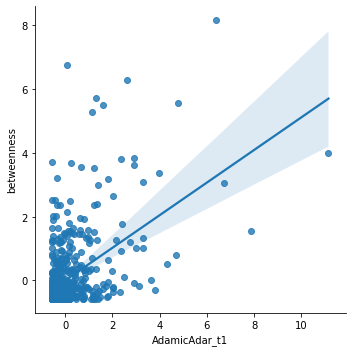

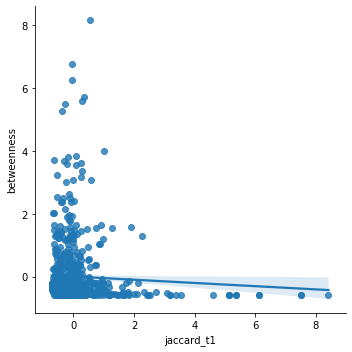

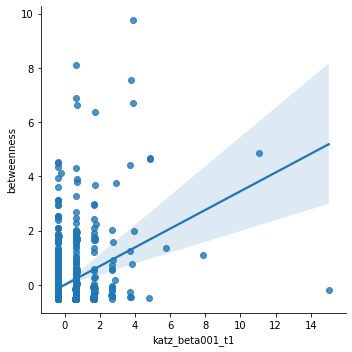

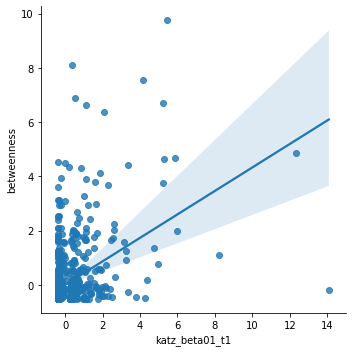

In [237]:
import matplotlib.pyplot as plt

for i, key in enumerate(weight_betweenness.keys()):
    train_set_scaled = weight_betweenness[key]['train_set_scaled']
    sns.lmplot(x=key, y='betweenness', data=train_set_scaled, fit_reg=True)

In [211]:
train_set_scaled

,AdamicAdar_t1,betweenness
0,11.146824,3.997309
1,7.866339,1.547516
2,6.708030,3.071469
3,6.397338,8.161672
4,4.765375,5.579535
...,...,...
710,-0.568046,-0.021022
711,-0.568046,-0.579572
712,-0.568046,-0.411766
713,-0.568046,0.237455


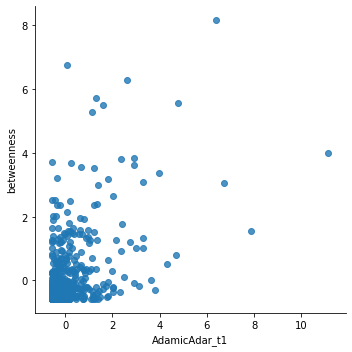

In [235]:
import seaborn as sns
# sns_current_palette = sns.palplot(sns.color_palette("hls", 8))
